# Processing Simulation Data to Generate Intensity Values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## File Names & Tests

0. The original photon file(Before calculating distributions) : 0.3GBs
1. fa_1_wv_1_sa_0.1_ns_1_ms_5.csv   :  20 points, Log spacing, starts with 0 though
2. fa_1_wv_1_sa_0.1_ns_1_ms_5_lin.csv   :    50 points, Linear spacing, min value to max value per m.
3. fa_1_wv_1_sa_0.1_ns_1_ms_5_fd.csv    : Automatically determine # of bins, min value to max, linear. Its a massive file!




In [2]:
simulation_data = pd.read_csv('../data/fa_1_wv_1_sa_0.1_ns_1_ms_5_fd.csv', dtype={'Ppath Medium' : np.int32, 'Deepest Layer': np.int32, 'Count': np.int32})

In [3]:
simulation_data.head()

,X,Y,Z,Ppath Medium,Deepest Layer,Bin Center,Count
0,110.0,100.0,71.0,1,1,0.126453,10384
1,110.0,100.0,71.0,1,1,0.379100,12462
2,110.0,100.0,71.0,1,1,0.631748,13394
3,110.0,100.0,71.0,1,1,0.884395,13305
4,110.0,100.0,71.0,1,1,1.137042,13143


## Determining SDD

Out of X and Y, only one of the co-ordinates should change. We use this to determine the SDD. The other co-ordinate would reprent the source position(on that axis). Replace the X,Y and Z in our data with their corresponding SDD.

In [4]:
varying_coordinate = 'X' if len(simulation_data['X'].unique()) > 1 else 'Y'
fixed_coordinate = 'X' if varying_coordinate == 'Y' else 'Y'
source_coordinate = simulation_data[fixed_coordinate][0] 


simulation_data['SDD'] = (simulation_data[varying_coordinate] - source_coordinate).astype(np.int32)  # in mm
simulation_data.drop(['X', 'Y', 'Z'], axis=1, inplace=True)
simulation_data.head(10)

,Ppath Medium,Deepest Layer,Bin Center,Count,SDD
0,1,1,0.126453,10384,10
1,1,1,0.379100,12462,10
2,1,1,0.631748,13394,10
3,1,1,0.884395,13305,10
4,1,1,1.137042,13143,10
5,1,1,1.389690,12419,10
6,1,1,1.642337,11686,10
7,1,1,1.894985,10941,10
8,1,1,2.147632,10507,10
9,1,1,2.400279,9930,10


## Visualizing the Path Distributions
How do the porbability density functions look? What is the best way to define the distribution for them?
(# TODO)


## Estimating Intensity in Post-process from Absorption Co-eff

First lets define a test $\mu$ for each layer. For our data, we have 8 layers. Define each co-eff as a Key -> Value pair of Layer Number (1 indexed) -> $\mu$.

Original optical properties from the simulations  
{'mua': 0.0, 'mus': 0.0, 'g': 1.0, 'n': 1.0},  
{'mua': 0.017, 'mus': 23.0, 'g': 0.9, 'n': 1.4},  
{'mua': 0.0085, 'mus': 12.0, 'g': 0.9, 'n': 1.4},  
{'mua': 0.016, 'mus': 10.8, 'g': 0.9, 'n': 1.4},  
{'mua': 0.0125, 'mus': 0.1, 'g': 0.9, 'n': 1.33},  
{'mua': 0.0157, 'mus': 6.81, 'g': 0.9, 'n': 1.3},  
{'mua': 0.0175, 'mus': 35.0, 'g': 0.9, 'n': 1.3},  
{'mua': 0.15058259000000002, 'mus': 6.1, 'g': 0.8, 'n': 1.3},  
{'mua': 0.0187, 'mus': 12.2, 'g': 0.9, 'n': 1.3}  

In [5]:
mu_map = {1: 0.0017, 2: 0.00085, 3: 0.0016, 4: 0.00125, 5: 0.00157, 6: 0.00175, 7: 0.015058259000000002, 8: 0.00187}

### Finding Out the normalizing factor $I_{n,0}$

The $I_{n,0}$ factor should normalize the distribution (The counts in this case) such that the count sum is 1 for all n.
$$
I_{n,0} = \sum_d \sum_m p_{pl,m,n}(d)
$$
where $1 \leq m \leq n$. Where n is the deepest layer the photons reached and m is each layer within that path. The $p_{pl,m,n}$ from the paper is the distribution at each partial path length. It is analogous to our count.

In [6]:
# Step 1 - Normalize path distribution and Multiply multiply each distribution with exp(-$\mu$d)
normalization_factor = simulation_data.groupby(['Deepest Layer', 'SDD', 'Ppath Medium'])['Count'].transform('sum')
normalization_factor_grouped = simulation_data.groupby(['Deepest Layer', 'SDD'])['Count'].sum()
normalization_factor.head()

0    476081
1    476081
2    476081
3    476081
4    476081
Name: Count, dtype: int32

In [7]:
normalization_factor_grouped.head()

Deepest Layer  SDD
1              10      476081
               15        1389
               19           5
2              10     3006410
               15      450724
Name: Count, dtype: int32

We keep two versions of this normalization factor. The first series is the same length as the CSV file. i.e., it has one element corresponding to each row. Which makes it easy to divide the original Count column with this. The second series is group indexed. Which is a much shorter length series. Its length is equal to the number of combinations of SDD and n. We will need this in a later step.

### Normalizing
$$
p_{pl,m,n}'(d) = \frac{p_{pl,m,n}(d)}{I_{n,0}}
$$

In [8]:
# Normalization
simulation_data['Count'] = simulation_data['Count']/normalization_factor
simulation_data.head(10)

,Ppath Medium,Deepest Layer,Bin Center,Count,SDD
0,1,1,0.126453,0.021811,10
1,1,1,0.379100,0.026176,10
2,1,1,0.631748,0.028134,10
3,1,1,0.884395,0.027947,10
4,1,1,1.137042,0.027607,10
5,1,1,1.389690,0.026086,10
6,1,1,1.642337,0.024546,10
7,1,1,1.894985,0.022981,10
8,1,1,2.147632,0.022070,10
9,1,1,2.400279,0.020858,10


### Modifying Path Length Distributions

$$
p''_{pl,m,n}(d) = p'_{pl,m,n}(d)exp(-d\mu_{a,m})
$$

In [9]:
simulation_data['Weighted Ppath'] = simulation_data['Count'] * np.exp(-simulation_data['Bin Center']*[mu_map[medium] for medium in simulation_data['Ppath Medium']]) 
simulation_data.head()

,Ppath Medium,Deepest Layer,Bin Center,Count,SDD,Weighted Ppath
0,1,1,0.126453,0.021811,10,0.021807
1,1,1,0.379100,0.026176,10,0.026159
2,1,1,0.631748,0.028134,10,0.028104
3,1,1,0.884395,0.027947,10,0.027905
4,1,1,1.137042,0.027607,10,0.027553


### Intensity Per Deepest Layer

$$
I_n = I_{n,0}\prod_{m=1}^n\sum_j p_{pl,m,n}''(d_j)
$$

In [10]:
# Step 2 - Distribution sum(integration)
test = simulation_data.copy()
test = test.groupby(['Ppath Medium', 'Deepest Layer', 'SDD'], sort=False, as_index=False)['Weighted Ppath'].sum()
test.head(20)

,Ppath Medium,Deepest Layer,SDD,Weighted Ppath
0,1,1,10,0.985799
1,1,2,10,0.960470
2,2,2,10,0.973547
3,1,3,10,0.956185
4,2,3,10,0.921991
5,3,3,10,0.939754
6,1,4,10,0.952345
7,2,4,10,0.896637
8,3,4,10,0.792467
9,4,4,10,0.995093


In [11]:
# Step 3 = Product
test = test.groupby(['Deepest Layer', 'SDD'], sort=False)['Weighted Ppath'].prod()
test.head()

Deepest Layer  SDD
1              10     0.985799
2              10     0.935063
3              10     0.828481
4              10     0.673373
5              10     0.654131
Name: Weighted Ppath, dtype: float64

In [12]:
# Multiplying back by $I_{n,0}$
test = test * normalization_factor_grouped

In [13]:
# Sum up all layers
test = test.groupby(['SDD']).sum()
test

SDD
10     6.449617e+06
15     2.135872e+06
19     9.597715e+05
24     4.748428e+05
29     2.478779e+05
34     1.372287e+05
38     7.486709e+04
43     4.417574e+04
48     2.437842e+04
53     1.481115e+04
57     8.262857e+03
62     5.250552e+03
67     2.857756e+03
72     1.845976e+03
76     1.046552e+03
81     7.090726e+02
86     4.147989e+02
91     2.539261e+02
95     1.355144e+02
100    8.435296e+01
dtype: float64

In [14]:
test

SDD
10     6.449617e+06
15     2.135872e+06
19     9.597715e+05
24     4.748428e+05
29     2.478779e+05
34     1.372287e+05
38     7.486709e+04
43     4.417574e+04
48     2.437842e+04
53     1.481115e+04
57     8.262857e+03
62     5.250552e+03
67     2.857756e+03
72     1.845976e+03
76     1.046552e+03
81     7.090726e+02
86     4.147989e+02
91     2.539261e+02
95     1.355144e+02
100    8.435296e+01
dtype: float64

<AxesSubplot:xlabel='SDD'>

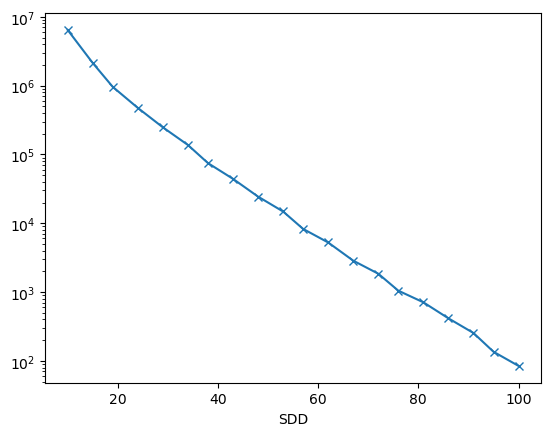

In [15]:
plt.yscale('log')
test.plot(marker='x')

### Regular Data (Without on-fly mu changes/The old way)


In [16]:
simulation_data1 = pd.read_csv('../data/fa_1_wv_1_sa_0.1_ns_1_ms_5_regular.csv')

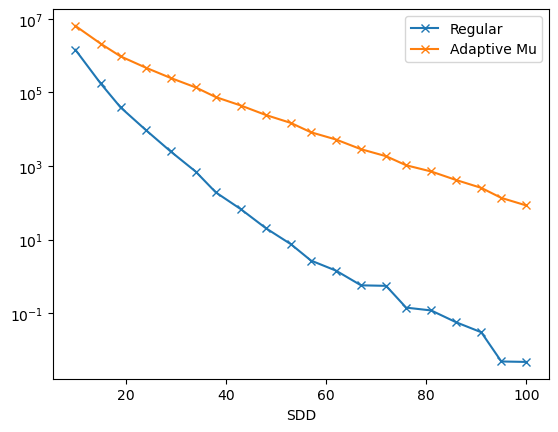

In [17]:
plt.plot(simulation_data1['X'] - 100, simulation_data1['Total'], marker='x', label='Regular')
test.plot(marker='x', label='Adaptive Mu')

plt.yscale('log')
plt.legend()

In [18]:
# Clean UP
test.name = "Intensity"
test2 = test.to_frame().reset_index()
test2.head()

,SDD,Intensity
0,10,6.449617e+06
1,15,2.135872e+06
2,19,9.597715e+05
3,24,4.748428e+05
4,29,2.478779e+05
